In [1]:
#!pip3 install imagecodecs
#!pip3 install numpy tensorflow matplotlib scipy
#!pip3 install pandas
#!pip3 install tifffile
#!pip3 install -U scikit-learn scipy matplotlib
#!pip3 install tensorflow-addons
#!pip3 install tensorflow_decision_forests --upgrade

In [2]:
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numba import cuda 

import os

import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf
import tifffile
from keras.layers import Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate


import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

2023-03-15 17:59:18.685524: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 17:59:19.386516: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 17:59:19.386550: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 17:59:21.692944: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
def reset_gpu():
    device = cuda.get_current_device()
    device.reset()

In [58]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.legend()
    plt.grid(True)

In [5]:
tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv').drop(['Unnamed: 0'],axis=1)
tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [6]:
tiles_expanded_rv.head()

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [7]:
tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
len(tiles)

10471

# Normalize data

In [9]:
def normalize_col(df, col_name):

    norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return norm

tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [10]:
tiles_expanded_rv.columns

Index(['Tile_ID', 'Long2', 'Lat2', 'Long1', 'Lat1', 'Mid_lat', 'Mid_long',
       'Stop_Signs', 'Paving_historical', 'Paving_future', 'Bus_stop',
       'Collisions_Future', 'Collisions_Historical', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U', 'Collisions_Future_binary',
       'Collisions_Historical_binary', 'Mid_lat_norm', 'Mid_long_norm'],
      dtype='object')

In [11]:
MODEL_TYPE='linear' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = tiles_expanded_rv['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID','Collisions_Historical_binary', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future_binary']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    input_y,
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



In [12]:
# np.asarray(x_train[['Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32').shape

In [13]:
len(x_train)

8376

In [14]:
len(y_train)

8376

In [15]:
len(x_test)

2095

In [16]:
len(y_test)

2095

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [17]:
IMAGE_PATH = '../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/' 

In [18]:
#eda
img = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [19]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [20]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [21]:
#example of accessing RGB digits and storing average in a list

list_ = []

print(img[0][0])
print([np.mean(img[0][0][0:3]), img[0][0][3]])

for i in img:
    for j in i:
        list_.append([np.mean(j[0:3]), j[3]])

print(list_[0])

[185. 177. 160. 130.]
[174.0, 130.0]
[174.0, 130.0]


In [22]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        #image_grayscale = []

        #for i in image:
        #    for j in i:
        #        image_grayscale.append([np.mean(j[0:3]), j[3]])
            
        # append to images
        data_mini.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [23]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [24]:
np.shape(images_mini)

(8376,)

In [25]:
images_mini

array([125.19414, 130.83464, 145.29156, ..., 153.39537, 129.47469,
       121.93695], dtype=float32)

In [26]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [27]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [28]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [29]:
street_mini_reshaped = street_mini.reshape(8376,11)
np.shape(street_mini_reshaped)

(8376, 11)

In [30]:
images_mini_reshaped = images_mini.reshape(8376,1)
np.shape(images_mini_reshaped)

(8376, 1)

In [31]:
input_image_street = np.hstack((street_mini_reshaped, images_mini_reshaped))


In [32]:
# input_image_street = input_image_street.reshape((8376,1,1, 111307))

In [33]:
input_image_street[0]

array([  2.        ,   0.40708277,   0.69343007,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        , 125.19414   ],
      dtype=float32)

In [34]:
input_image_street.shape
# y_train.shape

(8376, 12)

In [35]:
np.shape(y_train)

(8376,)

**Model #3: Random Forest using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
https://www.youtube.com/watch?v=5qgk9QJ4rdQ&t=181s

In [36]:
# Train a Random Forest model.

rf_model = tfdf.keras.RandomForestModel(task=2, num_trees=100)

rf_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpr0i3bdes as temporary training directory
Reading training dataset...


2023-03-15 18:00:14.921095: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-15 18:00:14.922043: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 18:00:14.922090: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-13-91): /proc/driver/nvidia/version does not exist
2023-03-15 18:00:14.923766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Training dataset read in 0:00:04.748024. Found 8376 examples.
Training model...


[INFO 2023-03-15T18:00:20.517672342+00:00 kernel.cc:1214] Loading model from path /tmp/tmpr0i3bdes/model/ with prefix 56860f20d7dc4580


Model trained in 0:00:01.123367
Compiling model...


[INFO 2023-03-15T18:00:20.802031823+00:00 decision_forest.cc:661] Model loaded with 100 root(s), 104210 node(s), and 11 input feature(s).
[INFO 2023-03-15T18:00:20.802077748+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-03-15T18:00:20.802102502+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [37]:
# Train a Random Forest model.

rf_model2 = tfdf.keras.RandomForestModel(task=2, num_trees=300)

rf_model2.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmph8pwjojs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.327746. Found 8376 examples.
Training model...


[INFO 2023-03-15T18:00:25.362723859+00:00 kernel.cc:1214] Loading model from path /tmp/tmph8pwjojs/model/ with prefix 8f22a8e0790043aa


Model trained in 0:00:03.312080
Compiling model...


[INFO 2023-03-15T18:00:26.204880213+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 313632 node(s), and 11 input feature(s).
[INFO 2023-03-15T18:00:26.204932236+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [38]:
print(rf_model2.summary())

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.465754 ################
    2.  "data:0.5"  0.221680 #####
    3.  "data:0.2"  0.220910 #####
    4.  "data:0.3"  0.177408 ####
    5.  "data:0.1"  0.167681 ###
    6. "data:0.11"  0.130213 ##
    7.  "data:0.4"  0.102542 
    8.  "data:0.7"  0.081586 
    9. "data:0.10"  0.081407 
   10.  "data:0.6"  0.080768 
   11.  "data:0.9"  0.080762 

Variable Importance: NUM_AS_ROOT:
    1.  "data:0.0" 130.000000 ################
    2.  "d

In [39]:
##uncomment to show training log
#rf_model_train.make_inspector().training_logs()
rf_model2.make_inspector().evaluation()

Evaluation(num_examples=8376, accuracy=None, loss=None, rmse=0.9779595835804462, ndcg=None, aucs=None, auuc=None, qini=None)

In [40]:
x_test.columns

Index(['Tile_ID', 'Collisions_Historical', 'Mid_lat_norm', 'Mid_long_norm',
       'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U'],
      dtype='object')

In [41]:
#evaluate the model
rf_model2.evaluate(x_test[['Tile_ID', 'Collisions_Historical', 'Mid_lat_norm', 'Mid_long_norm',
       'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U']])

66/66 [==============================] - 0s 2ms/step - loss: 0.0000e+00


0.0

In [42]:
#make predictions from test set
pd.DataFrame(rf_model.predict(x_test[['Tile_ID', 'Collisions_Historical', 'Mid_lat_norm', 'Mid_long_norm',
       'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U']]))

66/66 [==============================] - 0s 1ms/step


,0
0,7.068793
1,6.344624
2,7.138793
3,8.319448
4,7.061317
...,...
2090,7.217875
2091,7.249133
2092,7.186068
2093,7.284544


66/66 [==============================] - 0s 1ms/step


array([[<Axes: title={'center': '0'}>]], dtype=object)

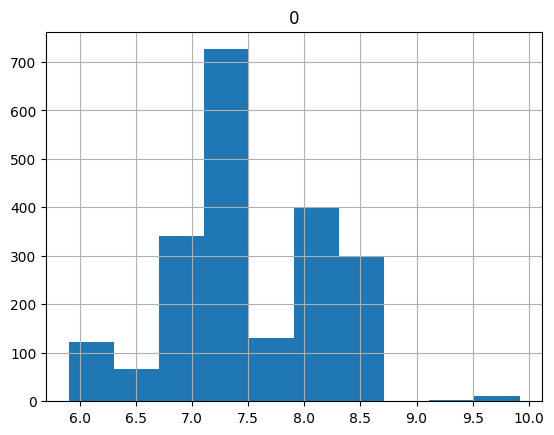

In [43]:
pd.DataFrame(rf_model.predict(x_test[['Tile_ID', 'Collisions_Historical', 'Mid_lat_norm', 'Mid_long_norm',
       'Stop_Signs', 'Paving_historical', 'Bus_stop', 'RTTYP_I', 'RTTYP_M',
       'RTTYP_O', 'RTTYP_S', 'RTTYP_U']])).hist()

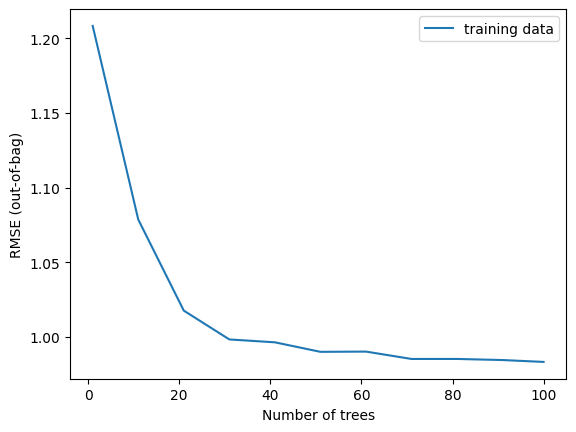

In [44]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.legend()
plt.show()

**Model #4: Gradient Boosted Tree using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [45]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=2)

gbt_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmp9asyue6_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.338741. Found 8376 examples.
Training model...


2023-03-15 18:00:28.477234: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-15 18:00:28.477277: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-15 18:00:28.477287: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-15 18:00:28.477907: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to SQUARED_ERROR
2023-03-15 18:00:28.477969: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 8376 example(s) and 12 feature(s).
2023-03-15 18:00:28.479386: I 

Model trained in 0:00:00.781847
Compiling model...


2023-03-15 18:00:29.233774: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 75
2023-03-15 18:00:29.236391: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 46 tree(s) i.e. 46  iteration(s).
2023-03-15 18:00:29.236584: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:46 valid-loss:0.914948 valid-rmse:0.914948
[INFO 2023-03-15T18:00:29.247444211+00:00 kernel.cc:1214] Loading model from path /tmp/tmp9asyue6_/model/ with prefix 4d6901c4b1374496
[INFO 2023-03-15T18:00:29.253320804+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [46]:
print(gbt_model.summary())

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.885751 ################
    2.  "data:0.5"  0.239186 #
    3. "data:0.11"  0.207357 
    4.  "data:0.2"  0.206792 
    5.  "data:0.1"  0.206223 
    6.  "data:0.3"  0.198554 
    7.  "data:0.4"  0.187651 
    8. "data:0.10"  0.173188 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 44.000000 ################
    2. "data:0.5"  2.000000 

Variable Importance: NUM_NODES:
    1.  "data:0.2" 221.000000 ############

In [47]:
##uncomment to show training log
#gbt_model.make_inspector().training_logs()
gbt_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=0.9149483442306519, rmse=0.9149483442306519, ndcg=None, aucs=None, auuc=None, qini=None)

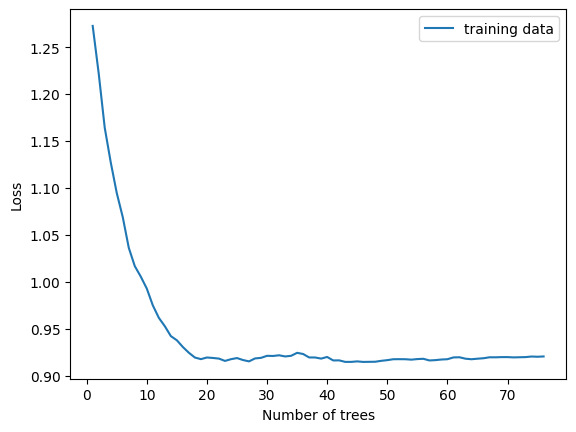

In [48]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.show()

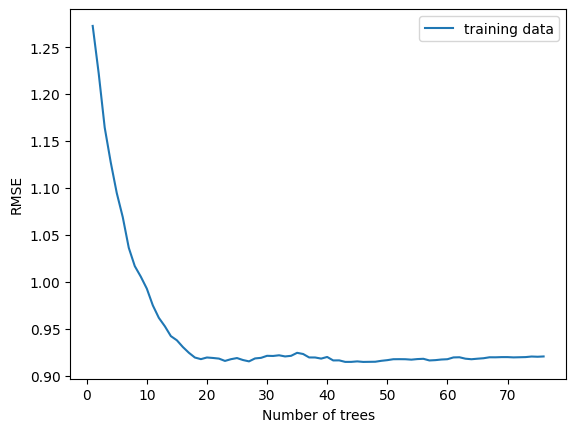

In [49]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

plt.show()

In [50]:
#evaluate the model
#gbt_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

In [51]:
#make predictions from test set
#pd.DataFrame(gbt_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))

**Baseline Linear Model**

In [60]:
# x: 'Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U'
# y: 'Collisions_Future'

def create_linear_model():
    # DENSE LAYERS 
    input = tf.keras.layers.Input(shape=(12,))

    outputs = layers.Dense(1)(input)

    linear_model = tf.keras.models.Model(inputs=input, outputs=outputs, name="linear_model")

    linear_model.summary()

    linear_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mse'
        )
    
    return linear_model

linear_model = create_linear_model()

history = linear_model.fit(input_image_street,
     y_train,
    epochs=100,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Model: "linear_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
210/210 [==============================] - 1s 2ms/step - loss: 17.3963 - val_loss: 1.5595
Epoch 2/100
210/210 [==============================] - 0s 2ms/step - loss: 1.4974 - val_loss: 1.3287
Epoch 3/100
210/210 [==============================] - 0s 2ms/step - loss: 1.3216 - val_loss: 1.1733
Epoch 4/100
210/210 [==============================] - 0s 2ms/step - loss: 1.2076 - val_loss: 1.0750
Epoch 5/100
210/210 [============================

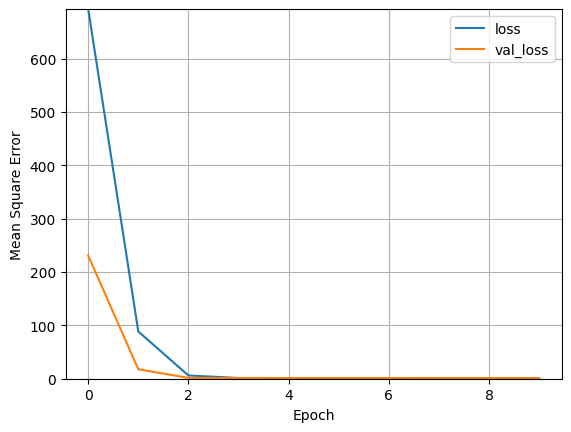

In [59]:
plot_loss(history)

In [54]:
# def build_model1():
#     model = keras.Sequential([
#         layers.Dense(64, activation=tf.nn.relu, input_shape=(12,)),
#         layers.Dense(64, activation=tf.nn.relu),
#         layers.Dense(1)
#     ])
    
#     optimizer = tf.keras.optimizers.RMSprop(0.001)
    
#     model.compile(loss='mse',
#                   optimizer=optimizer,
#                   metrics=['mse'])
    
#     return model

In [55]:
# model1 = build_model1()

In [56]:
# model1.summary()

In [57]:
# history1 = model1.fit(
#     input_image_street,
#      y_train,
#     epochs=100,
#     # Suppress logging.
#      verbose=1,
#     # Calculate validation results on 20% of the training data.
#     validation_split = 0.2)